<a href="https://colab.research.google.com/github/Jung0Jin/Pytorch_study/blob/master/2.%EC%84%A0%ED%98%95%ED%9A%8C%EA%B7%80%ED%99%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2.선형회귀활용

공부한 선형회귀를 활용해보자.

##2.1데이터 다운로드

아래 링크 클릭하면 구글 드라이브에 저장된 데이터가 있다. 눌러서 다운로드 받으면 된다. 

출처 : https://dacon.io/competitions/open/235576/overview/

https://drive.google.com/open?id=1Fr-DRWYo4HqI9Rz57j5Bi16SVkSt7rPA #train.csv

https://drive.google.com/open?id=1Jm6ZoJGrC10-P2GK965Nd0vc0NAs07Sx #test.csv

https://drive.google.com/open?id=16SI0RPmqyBnOn-bZqtUv95NKKsLJcpS5 #submission.csv


##2.2 데이터 불러오기

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#한글 출력 설정
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
import matplotlib as mpl 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [80]:
train = pd.read_csv('/content/drive/My Drive/데이콘 따릉이 데이터/train.csv')
train.fillna(train.mean(), inplace=True)
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [81]:
test = pd.read_csv('/content/drive/My Drive/데이콘 따릉이 데이터/test.csv')
test.fillna(test.mean(), inplace=True)
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [82]:
print(train.shape, test.shape)

(1459, 11) (715, 10)


데이콘 따릉이 데이터는 10개의 특징 데이터와 1개의 타겟 데이터로 구성된다.

*   특징 데이터

> id : 자전거 고유 id

> hour : 자전거를 사용한 시간

> temperature : 기온

> precipitation : 비가 오지 않으면 0, 오면 1

> windspeed : 풍속(평균)

> humidity : 습도

> visibility : 가시 거리

> ozone : 오존

> pm10 : 미세먼지

> pm2.5 : 미세먼지

* 타겟 데이터

> count : 시간에 따른 따릉이 대여 수

In [105]:
x_temp = train.drop(['count'], axis=1)
x_temp = x_temp.apply(lambda x: (x - x.mean()) / x.std())

# 데이터프레임 형식은 텐서로 못 바꾼다. 어레이로 만들어 주자.
x = x_temp.values 
y = train.values[:,-1:]

print(x.shape, y.shape)

(1459, 10) (1459, 1)


##2.3 커스텀 데이터셋 만들기

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [0]:
class MyDataset(Dataset):
  #데이터셋의 전처리를 해주는 부분
  def __init__(self):
    self.x_data = torch.tensor(x, dtype=torch.float)
    self.y_data = torch.tensor(y, dtype=torch.float)
    
  #데이터셋의 길이, 즉 총 샘플의 수를 적어주는 부분
  def __len__(self):
    return len(self.x_data)
  
  #데이터셋에서 특정 1개의 샘플을 가져오는 함수
  def __getitem__(self, idx):
    x = self.x_data[idx]
    y = self.y_data[idx]
    return x, y

In [0]:
dataset = MyDataset()

In [109]:
# train set 와 validation set로 나누는 비율 정하기

train_val_ratio = 0.8
train_size = int(len(dataset) * train_val_ratio)
val_size = len(dataset) - train_size
print(train_size, val_size)

# train set와 validation set로 나누자

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(len(train_dataset), len(val_dataset))

1167 292
1167 292


In [0]:
train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=len(val_dataset), shuffle=True)

##2.4 모델 학습하기

In [0]:
model = nn.Linear(10,1)
optimizer = optim.SGD(model.parameters(), lr=0.05)

nb_epochs = 100
train_losses = []
val_losses = []
for epoch in range(nb_epochs+1):
  for samples in train_loader:
    x_train, y_train = samples

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.mse_loss(prediction, y_train)

    # cost로 H(x) 계산
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    train_losses.append(cost.item())

  for samples in val_loader:
    x_val, y_val = samples
    prediction = model(x_val)
    cost = F.mse_loss(prediction, y_val)
    val_losses.append(cost.item())


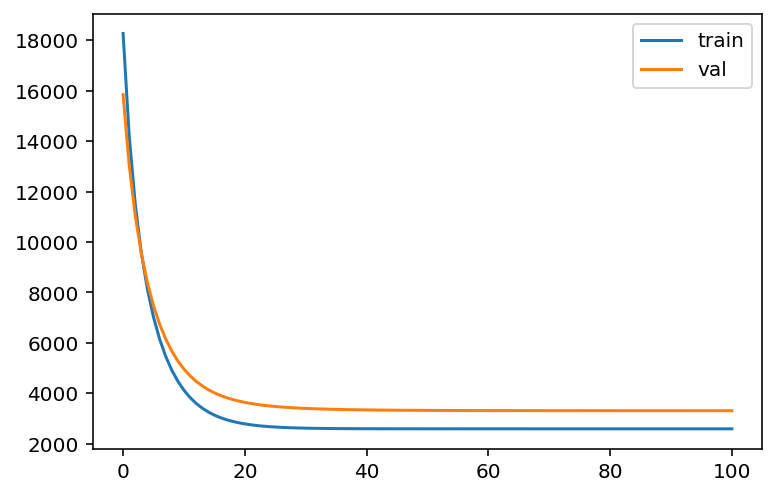

In [112]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

##2.5 예측하기

In [0]:
x_test = test.values
x_test = torch.tensor(x_test, dtype=torch.float)

In [0]:
prediction = model(x_test)
# prediction 은 tensor 값이므로 어레이 형식으로 바꿔준다.
prediction = prediction.detach().numpy()

##2.6 submission 만들기

In [0]:
submission = pd.DataFrame(data=prediction, columns=['count'])
submission['id'] = test['id']
submission = submission.set_index('id')
submission.to_csv('my_submission.csv', index=True)